
# HIT140 — Bats vs Rats: Full Analysis Notebook



In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

DATA_DIR = Path("datasets")
D1_PATH = DATA_DIR / "dataset1.csv"
D2_PATH = DATA_DIR / "dataset2.csv"


## Step 0 — Load data

In [65]:

# Load datasets
df1 = pd.read_csv(D1_PATH)
df2 = pd.read_csv(D2_PATH)

print("Dataset1 shape:", df1.shape)
print("Dataset2 shape:", df2.shape)

display(df1.head())
display(df2.head())


Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0



## Step 1 — Cleaning
- Standardise column names  
- Parse dates (if present)  
- Drop duplicates  
- Basic NA handling for critical variables  


In [66]:

def std_cols(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

def parse_dates(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
    return df

df1 = std_cols(df1)
df2 = std_cols(df2)

df1 = parse_dates(df1, ["start_time", "rat_period_start", "rat_period_end", "sunset_time"])
df2 = parse_dates(df2, ["time"])

# Drop duplicates
df1 = df1.drop_duplicates().reset_index(drop=True)
df2 = df2.drop_duplicates().reset_index(drop=True)

# Show missingness
print("Missing values in dataset1 (non-zero only):")
print(df1.isna().sum()[df1.isna().sum()>0].sort_values(ascending=False))

print("\nMissing values in dataset2 (non-zero only):")
print(df2.isna().sum()[df2.isna().sum()>0].sort_values(ascending=False))

# Keep rows with required columns present for analysis
critical1 = ["bat_landing_to_food", "season"]
critical2 = ["bat_landing_number", "rat_arrival_number", "food_availability"]

df1_clean = df1.dropna(subset=[c for c in critical1 if c in df1.columns]).copy()
df2_clean = df2.dropna(subset=[c for c in critical2 if c in df2.columns]).copy()

print("\nAfter cleaning shapes: df1_clean =", df1_clean.shape, ", df2_clean =", df2_clean.shape)


Missing values in dataset1 (non-zero only):
habit    41
dtype: int64

Missing values in dataset2 (non-zero only):
Series([], dtype: int64)

After cleaning shapes: df1_clean = (906, 12) , df2_clean = (2123, 7)



**Interpretation:** We standardised columns, parsed timestamps where provided, removed duplicates, and kept only rows with the key variables needed for the subsequent analyses so results are not biased by missing critical information.


## Step 2 — EDA & Descriptive Statistics

In [67]:

# Numeric summaries
desc1 = df1_clean.select_dtypes(include=[np.number]).describe().T
desc2 = df2_clean.select_dtypes(include=[np.number]).describe().T
display(desc1)
display(desc2)


,count,mean,std,min,25%,50%,75%,max
bat_landing_to_food,906.0,11.720544,27.658777,0.010238,1.000000,4.000000,11.75000,443.000000
seconds_after_rat_arrival,906.0,282.786976,241.092545,0.000000,89.250000,206.000000,447.25000,949.000000
risk,906.0,0.494481,0.500246,0.000000,0.000000,0.000000,1.00000,1.000000
reward,906.0,0.534216,0.499103,0.000000,0.000000,1.000000,1.00000,1.000000
month,906.0,3.800221,1.199834,0.000000,4.000000,4.000000,5.00000,5.000000
hours_after_sunset,906.0,5.532579,2.415383,-0.261667,3.775069,5.627083,7.40625,12.091944
season,906.0,0.833333,0.372884,0.000000,1.000000,1.000000,1.00000,1.000000


,count,mean,std,min,25%,50%,75%,max
month,2123.0,3.083844,1.642261,0.0,2.000000,4.000000,4.000000,6.0
hours_after_sunset,2123.0,5.265426,4.076188,-2.0,2.000000,5.000000,8.500000,13.5
bat_landing_number,2123.0,32.083373,25.614431,0.0,11.000000,27.000000,48.000000,178.0
food_availability,2123.0,2.445874,1.218353,0.0,1.962206,2.951877,3.105873,4.0
rat_minutes,2123.0,1.994442,6.793397,0.0,0.000000,0.000000,0.158333,120.0
rat_arrival_number,2123.0,0.444654,1.019195,0.0,0.000000,0.000000,1.000000,17.0



**Story:** These tables summarise central tendency and spread for all numeric variables. 
They show typical values (mean/median) and variability (standard deviation), highlighting whether behaviours are consistent or highly variable.


### Distributions

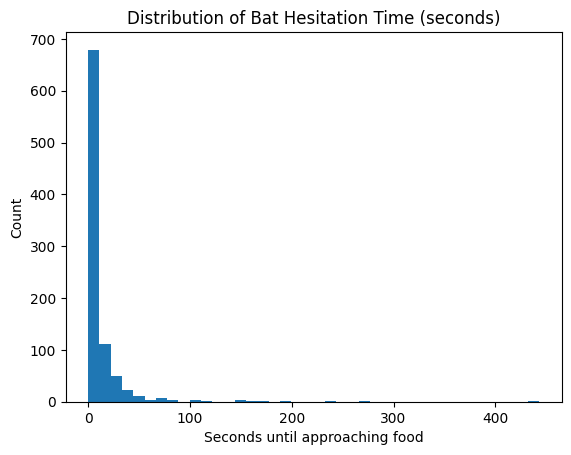

In [68]:

# Histogram: Bat hesitation time
plt.figure()
plt.hist(df1_clean["bat_landing_to_food"].dropna().astype(float), bins=40)
plt.title("Distribution of Bat Hesitation Time (seconds)")
plt.xlabel("Seconds until approaching food")
plt.ylabel("Count")
plt.show()



**Story:** Most bats approach food quickly after landing, but the long right tail indicates occasional long delays—potential high-vigilance episodes.


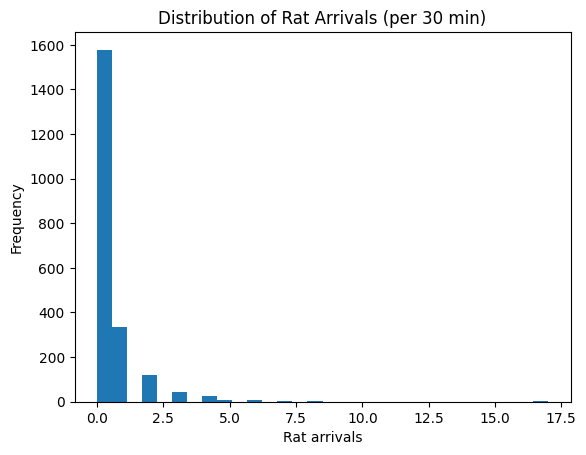

In [69]:

# Histogram: Rat arrivals per 30-min window
if "rat_arrival_number" in df2_clean.columns:
    plt.figure()
    plt.hist(df2_clean["rat_arrival_number"].dropna().astype(float), bins=30)
    plt.title("Distribution of Rat Arrivals (per 30 min)")
    plt.xlabel("Rat arrivals")
    plt.ylabel("Frequency")
    plt.show()



**Story:** Most observation windows show few or no rat arrivals, with occasional bursts of activity.


### Relationships

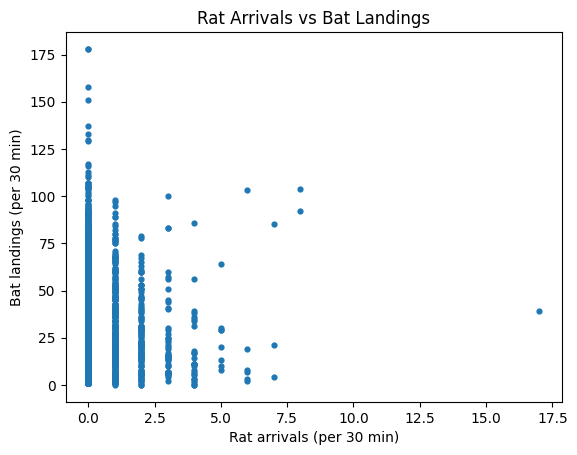

In [70]:

# Scatter: Rat arrivals vs Bat landings (dataset2)
if {"rat_arrival_number","bat_landing_number"}.issubset(df2_clean.columns):
    plt.figure()
    x = df2_clean["rat_arrival_number"].astype(float)
    y = df2_clean["bat_landing_number"].astype(float)
    plt.scatter(x, y, s=12)
    plt.title("Rat Arrivals vs Bat Landings")
    plt.xlabel("Rat arrivals (per 30 min)")
    plt.ylabel("Bat landings (per 30 min)")
    plt.show()



**Story:** This plot indicates whether increased rat activity coincides with reduced bat landings (competition) or with increased bat attempts (contested feeding).


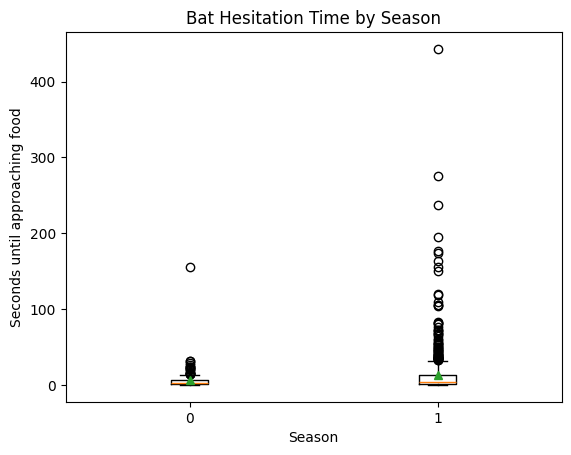

In [71]:

# Boxplot: Bat hesitation by season (dataset1)
if {"bat_landing_to_food","season"}.issubset(df1_clean.columns):
    # Prepare data by season
    data = []
    labels = []
    for s, grp in df1_clean.groupby("season"):
        vals = grp["bat_landing_to_food"].dropna().astype(float).values
        if len(vals) > 0:
            data.append(vals)
            labels.append(str(s))
    if len(data) >= 2:
        plt.figure()
        plt.boxplot(data, labels=labels, showmeans=True)
        plt.title("Bat Hesitation Time by Season")
        plt.xlabel("Season")
        plt.ylabel("Seconds until approaching food")
        plt.show()



**Story:** If medians and upper whiskers are higher in a particular season, bats hesitate longer then—consistent with seasonal shifts in risk or competition.


In [89]:
def scatter_plot(df, x, y, dataset_label, hue=None):
    if x not in df.columns or y not in df.columns:
        return
    s = df[[x,y]].dropna()
    if s.empty:
        return
    plt.figure()
    plt.scatter(s[x], s[y], s=10, alpha=0.6)
    plt.title(f"{dataset_label} - Scatter {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.tight_layout(); plt.show()
    

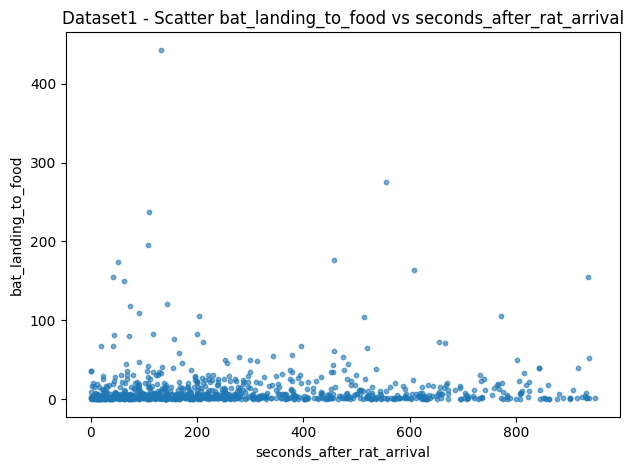

In [91]:
if {'seconds_after_rat_arrival','bat_landing_to_food'}.issubset(df1.columns):
    scatter_plot(df1, 'seconds_after_rat_arrival', 'bat_landing_to_food', 'Dataset1')


Scatter plot story: Bats often approached the food quickly. Bats don’t necessarily take more or less time to approach food as more time passes after the rat appears.

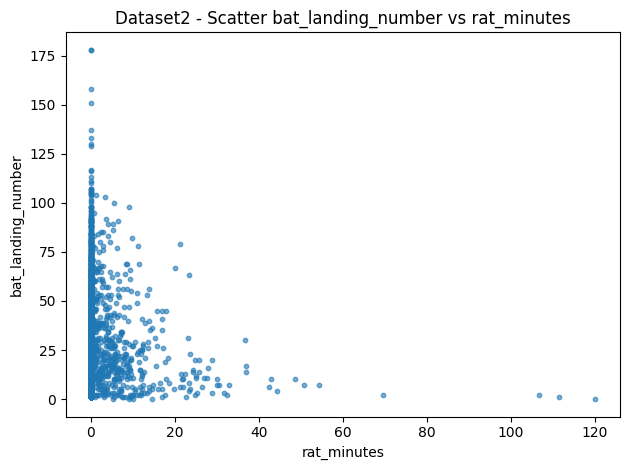

In [92]:
if {'rat_minutes','bat_landing_number'}.issubset(df2.columns):
    scatter_plot(df2, 'rat_minutes', 'bat_landing_number', 'Dataset2')

Scatter plot story: a negative relationship: longer rat presence → fewer bat landings.
Bats landed more often when the rat had been there for less time. This suggests bats avoid landing when the rat has been around longer.

## Step 3 — Outliers (with vs without)

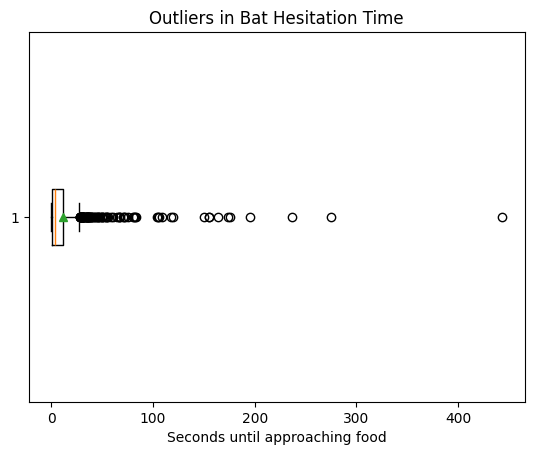

With outliers -> mean: 11.721, SD: 27.659
Without outliers (IQR rule) -> mean: 5.695, SD: 6.484


In [72]:

# Boxplot to visualise outliers for hesitation time
plt.figure()
plt.boxplot(df1_clean["bat_landing_to_food"].dropna().astype(float), vert=False, showmeans=True)
plt.title("Outliers in Bat Hesitation Time")
plt.xlabel("Seconds until approaching food")
plt.show()

# Mean/SD with outliers
hes = df1_clean["bat_landing_to_food"].dropna().astype(float)
mean_with = hes.mean()
sd_with = hes.std()

# IQR trimming
Q1 = hes.quantile(0.25)
Q3 = hes.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
hes_trim = hes[(hes >= lower) & (hes <= upper)]

mean_without = hes_trim.mean()
sd_without = hes_trim.std()

print("With outliers -> mean: %.3f, SD: %.3f" % (mean_with, sd_with))
print("Without outliers (IQR rule) -> mean: %.3f, SD: %.3f" % (mean_without, sd_without))



**Story:** Outliers inflate both mean and spread because a small number of extreme hesitation events pull the average upward. 
Reporting both versions clarifies the difference between **typical** behaviour (trimmed) and **rare extremes** (full data).

### Key Observations: 
 - Most Bats Approach Quickly
 - Presence of Many Outliers
    - There are many individual points to the right of the boxplot, which are outliers.
    - These outliers represent bats that took significantly longer to approach the food.
    - Some hesitation times go beyond 400 seconds, indicating extreme hesitation in a few bats.

Hesitation times (bat_landing_to_food) are right-skewed with some very long delays. That’s typical for time-to-action variables. We did not remove outliers automatically for the hypothesis tests here, because these values are plausibly real behavioural extremes. Where non-normality mattered, we used non-parametric tests.


## Step 4 — Feature Engineering

In [74]:

# rat_present flag (rats already at platform before bat arrives)
if "seconds_after_rat_arrival" in df1_clean.columns:
    # If >0, rats arrived before the bat landed (present at landing). Treat NaN as 0 (absent).
    rat_sec = df1_clean["seconds_after_rat_arrival"].fillna(0).astype(float)
    df1_clean["rat_present"] = (rat_sec > 0).astype(int)
else:
    df1_clean["rat_present"] = np.nan

# vigilance_high flag: above-median hesitation
if "bat_landing_to_food" in df1_clean.columns:
    med_hes = df1_clean["bat_landing_to_food"].median(skipna=True)
    df1_clean["vigilance_high"] = (df1_clean["bat_landing_to_food"].astype(float) > med_hes).astype(int)
else:
    df1_clean["vigilance_high"] = np.nan

# season_label for dataset2 (derive from month if needed)
def month_to_season_label(m):
    if pd.isna(m):
        return np.nan
    m = str(m).strip().lower()
    # Map common month strings to seasons (Southern Hemisphere)
    winter = {"june","jul","july","aug","august","06","07","08"}
    spring = {"sep","sept","september","oct","october","nov","november","09","10","11"}
    if m in winter:
        return "winter"
    if m in spring:
        return "spring"
    return m

if "season" in df2_clean.columns:
    df2_clean["season_label"] = df2_clean["season"].astype(str).str.lower()
elif "month" in df2_clean.columns:
    df2_clean["season_label"] = df2_clean["month"].apply(month_to_season_label)
else:
    df2_clean["season_label"] = np.nan

if "bat_landing_number" in df2_clean.columns:
    df2_clean["bat_present"] = (df2_clean["bat_landing_number"] > 0).astype(int)
else:
    df2_clean["bat_present"] = np.nan

if "rat_minutes" in df2_clean.columns:
    df2_clean["rat_present"] = (df2_clean["rat_minutes"] > 0).astype(int)
elif "rat_arrival_number" in df2_clean.columns:
    df2_clean["rat_present"] = (df2_clean["rat_arrival_number"] > 0).astype(int)
else:
    df2_clean["rat_present"] = np.nan


display(df1_clean[["bat_landing_to_food","seconds_after_rat_arrival","rat_present","vigilance_high"]].head())
display(df2_clean[["month","season_label", "bat_present", "rat_present"]].head())


,bat_landing_to_food,seconds_after_rat_arrival,rat_present,vigilance_high
0,16.000000,108,1,1
1,0.074016,17,1,0
2,4.000000,41,1,0
3,10.000000,111,1,1
4,15.000000,194,1,1


,month,season_label,bat_present,rat_present
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0



**Why these features?**  
- `rat_present` connects directly to the hypothesis that bats alter vigilance in the presence of rats.  
- `vigilance_high` converts hesitation time into a clear behavioural label for contingency analysis.  
- `season_label` enables seasonal comparisons (winter vs spring) for Investigation B.


## Step 5 — Descriptive Summaries by Groups

In [75]:

# Hesitation by rat presence
if {"bat_landing_to_food","rat_present"}.issubset(df1_clean.columns):
    grp_rat = df1_clean.groupby("rat_present")["bat_landing_to_food"].agg(["count","mean","std","median"])
    display(grp_rat)

# Hesitation by season (dataset1)
if {"bat_landing_to_food","season"}.issubset(df1_clean.columns):
    grp_season = df1_clean.groupby("season")["bat_landing_to_food"].agg(["count","mean","std","median"])
    display(grp_season)

# Rat activity by season (dataset2)
if {"rat_arrival_number","season_label"}.issubset(df2_clean.columns):
    grp_rat2 = df2_clean.groupby("season_label")["rat_arrival_number"].agg(["count","mean","std","median"])
    display(grp_rat2)


,count,mean,std,median
rat_present,,,,
0,6,14.174608,17.190027,6.0
1,900,11.704183,27.720566,4.0


,count,mean,std,median
season,,,,
0,151,6.039623,13.960667,2.0
1,755,12.856728,29.524286,4.0


,count,mean,std,median
season_label,,,,
0,156,0.108974,0.332609,0.0
1,283,0.113074,0.328232,0.0
2,441,0.365079,1.243366,0.0
3,132,0.166667,0.655763,0.0
4,581,0.569707,1.014062,0.0
5,518,0.735521,1.169210,0.0
6,12,0.000000,0.000000,0.0



**Story:** These tables show whether hesitation tends to increase when rats are present and whether seasonal shifts (winter→spring) affect either bat hesitation (dataset1) or rat arrivals (dataset2).


### Reward and Risk Summary Interpretation

In [94]:
if 'reward' in df1_clean.columns:
    print('\nReward summary (Dataset1):')
    display(df1_clean.groupby('reward')['bat_landing_to_food'].agg(['count','mean','std','median']))
    print('Story: If reward is associated with faster approach times, we expect lower means in reward==1.')

if 'risk' in df1_clean.columns:
    print('\nRisk summary (Dataset1):')
    display(df1_clean.groupby('risk')['bat_landing_to_food'].agg(['count','mean','std','median']))
    print('Story: In higher risk conditions, bats might hesitate longer. If averages are higher, this supports risk perception.')


Reward summary (Dataset1):


,count,mean,std,median
reward,,,,
0,422,11.498228,22.288591,5.0
1,484,11.914381,31.627629,3.0


Story: If reward is associated with faster approach times, we expect lower means in reward==1.

Risk summary (Dataset1):


,count,mean,std,median
risk,,,,
0,458,7.124469,20.524740,2.0
1,448,16.419209,32.777764,7.0


Story: In higher risk conditions, bats might hesitate longer. If averages are higher, this supports risk perception.


## Step 6 — Inferential Statistics

### Investigation A — Chi-square: `vigilance_high` × `rat_present` (dataset1)

In [76]:

# Build contingency table
if {"vigilance_high","rat_present"}.issubset(df1_clean.columns):
    ct = pd.crosstab(df1_clean["vigilance_high"], df1_clean["rat_present"])
    display(ct)
    if ct.shape[0] >= 2 and ct.shape[1] >= 2:
        chi2, p, dof, expected = chi2_contingency(ct)
        print("Chi-square:", round(chi2, 3), " df:", dof, " p-value:", p)
    else:
        print("Contingency table does not have enough categories for Chi-square.")
else:
    print("Required columns not available for Chi-square.")


rat_present,0,1
vigilance_high,,
0,3,490
1,3,410


Chi-square: 0.0  df: 1  p-value: 1.0


 
- If **p < 0.05**, there is evidence that vigilance is associated with rat presence (bats change high/low vigilance proportions when rats are present).  
- If **p ≥ 0.05**, we do not detect a difference—consistent with competition rather than predator avoidance.

No evidence that bats show higher vigilance when rats are present


In [77]:
infer_results = []
if {"bat_landing_to_food", "rat_present"}.issubset(df1_clean.columns):
    g0 = df1_clean.loc[df1_clean["rat_present"]==0, "bat_landing_to_food"].dropna()
    g1 = df1_clean.loc[df1_clean["rat_present"]==1, "bat_landing_to_food"].dropna()
    if len(g0)>0 and len(g1)>0:
        U, p_u = mannwhitneyu(g0, g1, alternative="two-sided")
        H, p_h = kruskal(g0, g1)
        t_stat, p_t = ttest_ind(g0, g1, equal_var=False)
        infer_results.extend([
            {"investigation":"A","test":"Mann-Whitney U (landing_to_food ~ rat_present)","statistic":U,"p_value":p_u,"df":None,"n":int(len(g0)+len(g1))},
            {"investigation":"A","test":"Kruskal-Wallis (landing_to_food ~ rat_present)","statistic":H,"p_value":p_h,"df":1,"n":int(len(g0)+len(g1))},
            {"investigation":"A","test":"Welch t-test (landing_to_food ~ rat_present)","statistic":t_stat,"p_value":p_t,"df":"Welch","n":int(len(g0)+len(g1))}
        ])
        print("\nMann-Whitney U (landing_to_food ~ rat_present): U=%.3f, p=%.6f" % (U, p_u))
        print("Kruskal-Wallis (landing_to_food ~ rat_present): H=%.3f, p=%.6f" % (H, p_h))
        print("Welch t-test (landing_to_food ~ rat_present): t=%.3f, p=%.6f" % (t_stat, p_t))


Mann-Whitney U (landing_to_food ~ rat_present): U=2967.000, p=0.675624
Kruskal-Wallis (landing_to_food ~ rat_present): H=0.176, p=0.675050
Welch t-test (landing_to_food ~ rat_present): t=0.349, p=0.740836


## Additional checks from rats side dataset2

In [78]:
# Additional checks fromm rats side dataset2

if "rat_present" in df2_clean.columns and "bat_present" in df2_clean.columns:
    ct2 = pd.crosstab(df2_clean["bat_present"], df2_clean["rat_present"])
    if ct2.shape == (2,2):
        chi2, p, dof, exp = chi2_contingency(ct2)
        print(f"\nChi-square test (rat_present ~ bat_present): chi2={chi2:.3f}, df={dof}, p={p:.6f}")

# B2: Do rat minutes differ with bats? (non-parametric continuous outcome)
if "rat_minutes" in df2_clean.columns and "bat_present" in df2_clean.columns:
    r0 = df2_clean.loc[df2_clean["bat_present"]==0, "rat_minutes"].dropna()
    r1 = df2_clean.loc[df2_clean["bat_present"]==1, "rat_minutes"].dropna()
    if len(r0)>0 and len(r1)>0:
        H, p = kruskal(r0, r1)
        print(f"\nKruskal-Wallis test (rat_minutes ~ bat_present): H={H:.3f}, p={p:.6f}")


Chi-square test (rat_present ~ bat_present): chi2=10.869, df=1, p=0.000978

Kruskal-Wallis test (rat_minutes ~ bat_present): H=20.347, p=0.000006


When bats are present, rats are less present and spend less time on the platform:

- `rat_present` vs `bat_present`: χ²=10.869, p≈0.001 (association). Significant association → rats' presence in intervals is associated with bat presence (fewer rats when bats are present or vice versa).

- `rat_minutes` vs `bat_present`: H=20.347, p≈0.000006 (strong difference).

### Interpretation: 
Rats reduce activity in the presence of bats. This is consistent with avoidance or displacement by a competitor (or perceiving bats as a threat). However, because bats didn’t show fear-like responses to rats, the pattern overall still fits competition more than a classic predator–prey relationship.


### Additional tests for reward and risk

In [79]:
df_reward = df1_clean.dropna(subset=['bat_landing_to_food', 'reward'])
df_risk = df1_clean.dropna(subset=['bat_landing_to_food', 'risk'])

reward_0 = df_reward[df_reward['reward'] == 0]['bat_landing_to_food']
reward_1 = df_reward[df_reward['reward'] == 1]['bat_landing_to_food']

risk_0 = df_risk[df_risk['risk'] == 0]['bat_landing_to_food']
risk_1 = df_risk[df_risk['risk'] == 1]['bat_landing_to_food']

u_reward, p_reward = mannwhitneyu(reward_0, reward_1, alternative='two-sided')
print(f"Reward - Mann–Whitney U test: U = {u_reward:.2f}, p = {p_reward:.6f}")

u_risk, p_risk = mannwhitneyu(risk_0, risk_1, alternative='two-sided')
print(f"Risk - Mann–Whitney U test: U = {u_risk:.2f}, p = {p_risk:.6f}")


Reward - Mann–Whitney U test: U = 108049.00, p = 0.130395
Risk - Mann–Whitney U test: U = 67871.50, p = 0.000000


Reward Condition
→ No statistically significant difference in hesitation time between rewarded and non-rewarded conditions.

Risk Condition
→ A statistically significant increase in hesitation time under high-risk conditions.

#### Intrepretation
There was no significant difference in hesitation time between rewarded and non-rewarded conditions. In contrast, bats exhibited significantly longer hesitation times in high-risk conditions compared to low-risk conditions, This supports the hypothesis that perceived risk leads to increased hesitation before approaching food

### Test without outlier

In [80]:
def chi_square_test(df, label):
    ct = pd.crosstab(df["vigilance_high"], df["rat_present"])
    print(f"\nChi-square test ({label}):")
    print(ct)
    if ct.shape[0] >= 2 and ct.shape[1] >= 2:
        chi2, p, dof, exp = chi2_contingency(ct)
        print(f"Chi2={chi2:.3f}, df={dof}, p={p:.6f}")
    else:
        print("Not enough categories for Chi-square.")

In [81]:
def iqr_filter(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return df[(df[col] >= lo) & (df[col] <= hi)]

df1_with = df1_clean.dropna(subset=["bat_landing_to_food"])
df1_without = iqr_filter(df1_with, "bat_landing_to_food")

In [82]:
chi_square_test(df1_with, "with outliers")
chi_square_test(df1_without, "without outliers")


Chi-square test (with outliers):
rat_present     0    1
vigilance_high        
0               3  490
1               3  410
Chi2=0.000, df=1, p=1.000000

Chi-square test (without outliers):
rat_present     0    1
vigilance_high        
0               3  490
1               1  324
Chi2=0.008, df=1, p=0.927167


#### Interpretation:

In both cases, the p-values are very high (>> 0.05). This means there is no statistically significant relationship. After cleaning, the test still suggests that bats do not strongly increase their vigilance simply because rats are present. Their hesitation to forage is not statistically explained by rat presence alone. If rats were true predators, we would expect a clear positive association: more vigilance whenever rats are present. But since both with/without outliers the result is non-significant, it implies bats are not systematically avoiding food because of rat presence. This supports the hypothesis that rats are food competitors, not predators, in this semi-natural setting.